# CCC21 Refined - Improved Ensemble Approach

## CCC2 개선 + 최종 Refinement

### CCC2의 문제점:
- O ratio 과다 (78.1%) → 평가 규칙 위반 (20% 이하 추천)
- Threshold 고정 (0.5) → 최적화 안 됨
- Score normalization 불안정 (1000개 샘플만 사용)
- Weight 최적화 안 됨 (α=0.5, β=0.5 고정)
- Cold user 보호 없음
- User별 K 제한 미흡

### CCC21 개선사항 (4가지):
1. ✅ **Robust Score Normalization**: Train set 전체로 score range 계산
2. ✅ **Weight Optimization**: Grid search로 최적 α, β 탐색
3. ✅ **Threshold Tuning**: F1 maximization + O ratio 제약
4. ✅ **Hybrid Recommendation**: Threshold + Top-K 방식

### ★ Final Refinements (2가지):
5. ✅ **MIN_K Fallback**: Cold user (≤10 interactions) 최소 2개 추천 보장
6. ✅ **Rank Normalization**: Percentile 기반 정규화 옵션 추가

## Expected Performance:
- AUC-ROC: 0.95+ (CCC2 대비 개선)
- F1: 0.89+ (CCC2 대비 개선)
- O ratio: 20~50% (규칙 준수) ★

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import time

import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Device: {device} ({torch.cuda.get_device_name()})')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Device: {device}')
else:
    device = torch.device('cpu')
    print(f'Device: {device}')

Device: mps


## 1. Data Preprocessing

In [2]:
df = pd.read_csv('../data/train.csv')

print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user'].nunique()}")
print(f"Unique items: {df['item'].nunique()}")

GOOD_RATING_THRESHOLD = 4.0
n_good_purchases = (df['rating'] >= GOOD_RATING_THRESHOLD).sum()
print(f"\nGood purchases (rating >= {GOOD_RATING_THRESHOLD}): {n_good_purchases:,} ({100*n_good_purchases/len(df):.1f}%)")

user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
idx2user = {i: u for u, i in user2idx.items()}
idx2item = {i: it for it, i in item2idx.items()}

n_users, n_items = len(user2idx), len(item2idx)

df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)

print(f"\nUsers: {n_users}, Items: {n_items}")

Total interactions: 105,139
Unique users: 668
Unique items: 10321

Good purchases (rating >= 4.0): 51,830 (49.3%)

Users: 668, Items: 10321


In [3]:
# User별 K값 계산
user_interaction_count = df.groupby('user_idx').size().to_dict()

MAX_K = 100

def get_k_for_user(count):
    if count <= 10:
        return 2
    k = max(2, int(count * 0.2))
    return min(k, MAX_K)

user_k = {u: get_k_for_user(c) for u, c in user_interaction_count.items()}

print(f"User K statistics:")
print(f"  Mean: {np.mean(list(user_k.values())):.2f}")
print(f"  Median: {np.median(list(user_k.values())):.2f}")

User K statistics:
  Mean: 24.74
  Median: 14.00


In [4]:
# Train/Val/Test Split
train_data, val_data, test_data = [], [], []

for user_idx in range(n_users):
    user_df = df[df['user_idx'] == user_idx]
    
    good_purchases = user_df[user_df['rating'] >= GOOD_RATING_THRESHOLD][['user_idx', 'item_idx', 'rating']]
    bad_purchases = user_df[user_df['rating'] < GOOD_RATING_THRESHOLD][['user_idx', 'item_idx', 'rating']]
    
    if len(bad_purchases) > 0:
        train_data.append(bad_purchases[['user_idx', 'item_idx']])
    
    n_good = len(good_purchases)
    
    if n_good >= 3:
        good_purchases = good_purchases.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_end = int(0.7 * n_good)
        val_end = train_end + int(0.15 * n_good)
        
        train_end = max(1, train_end)
        val_end = max(train_end + 1, val_end)
        
        train_data.append(good_purchases.iloc[:train_end][['user_idx', 'item_idx']])
        val_data.append(good_purchases.iloc[train_end:val_end][['user_idx', 'item_idx']])
        test_data.append(good_purchases.iloc[val_end:][['user_idx', 'item_idx']])
    elif n_good == 2:
        good_purchases = good_purchases.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_data.append(good_purchases.iloc[:1][['user_idx', 'item_idx']])
        val_data.append(good_purchases.iloc[1:][['user_idx', 'item_idx']])
    elif n_good == 1:
        train_data.append(good_purchases[['user_idx', 'item_idx']])

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True) if val_data else pd.DataFrame(columns=['user_idx', 'item_idx'])
test_df = pd.concat(test_data, ignore_index=True) if test_data else pd.DataFrame(columns=['user_idx', 'item_idx'])

print(f"Train: {len(train_df):,}")
print(f"Val: {len(val_df):,}")
print(f"Test: {len(test_df):,}")

Train: 89,294
Val: 7,480
Test: 8,365


In [5]:
# User train items
user_train_items = defaultdict(set)
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    user_train_items[int(u)].add(int(i))

print(f"User train items ready: {len(user_train_items)} users")

User train items ready: 668 users


## 2. Load Pretrained Models

In [6]:
# Model definitions

class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=64, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
    
    def forward(self, edge_index, edge_weight):
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(all_emb)
        
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]


class LightGCN_with_Rating(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=64, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        
        self.rating_mlp = nn.Sequential(
            nn.Linear(emb_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    
    def forward(self, edge_index, edge_weight):
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(all_emb)
        
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]
    
    def predict_rating(self, user_idx, item_idx, edge_index, edge_weight):
        u_emb, i_emb = self.forward(edge_index, edge_weight)
        interaction = u_emb[user_idx] * i_emb[item_idx]
        rating_logit = self.rating_mlp(interaction).squeeze(-1)
        predicted_rating = torch.sigmoid(rating_logit) * 4.5 + 0.5
        return predicted_rating


print("Model classes defined")

Model classes defined


In [7]:
# Build graphs

def build_unweighted_graph():
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    
    edge_u2i = np.array([users, items + n_users])
    edge_i2u = np.array([items + n_users, users])
    edge_index = torch.LongTensor(np.concatenate([edge_u2i, edge_i2u], axis=1))
    
    num_nodes = n_users + n_items
    deg = torch.zeros(num_nodes).scatter_add(0, edge_index[0], torch.ones(edge_index.shape[1]))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    
    edge_weight = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
    
    return edge_index.to(device), edge_weight.to(device)


def build_rating_weighted_graph():
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    
    ratings = []
    for u, i in zip(users, items):
        rating = df[(df['user_idx'] == u) & (df['item_idx'] == i)]['rating'].values
        ratings.append(rating[0] if len(rating) > 0 else 3)
    ratings = np.array(ratings)
    
    rating_factors = 0.4 + 0.15 * ratings
    
    edge_u2i = np.array([users, items + n_users])
    edge_i2u = np.array([items + n_users, users])
    edge_index = torch.LongTensor(np.concatenate([edge_u2i, edge_i2u], axis=1))
    
    rating_factors_both = np.concatenate([rating_factors, rating_factors])
    
    num_nodes = n_users + n_items
    deg = torch.zeros(num_nodes).scatter_add(0, edge_index[0], torch.ones(edge_index.shape[1]))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    
    base_weight = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
    rating_weight = torch.FloatTensor(rating_factors_both)
    edge_weight = base_weight * rating_weight
    
    return edge_index.to(device), edge_weight.to(device)


cca_edge_index, cca_edge_weight = build_unweighted_graph()
ccb_edge_index, ccb_edge_weight = build_rating_weighted_graph()

print(f"Graphs built")

Graphs built


In [8]:
# Load models

EMB_DIM = 32
N_LAYERS = 2

cca_model = LightGCN(n_users, n_items, EMB_DIM, N_LAYERS).to(device)
cca_model.load_state_dict(torch.load('../cc_models/cca2_best.pt'))
cca_model.eval()

ccb_model = LightGCN_with_Rating(n_users, n_items, EMB_DIM, N_LAYERS).to(device)
ccb_model.load_state_dict(torch.load('../cc_models/ccb2_best.pt'))
ccb_model.eval()

print("✓ Models loaded")

✓ Models loaded


## 3. ★ Improvement 1: Robust Score Normalization

### CCC2 문제점:
- 1000개 샘플로만 score range 계산 → 불안정

### CCC21 개선:
- **Train set 전체**로 score range 계산
- Percentile 기반 normalization (outlier 대응)

In [9]:
print("Calculating robust score normalization parameters...")
print("Using FULL train set (not sampling)")

with torch.no_grad():
    cca_u_emb, cca_i_emb = cca_model(cca_edge_index, cca_edge_weight)

# Calculate scores for ALL train edges
print(f"Processing {len(train_df):,} train edges...")

cca_scores_train = []
ccb_ratings_train = []

batch_size = 10000
for i in range(0, len(train_df), batch_size):
    batch = train_df.iloc[i:i+batch_size]
    users_batch = batch['user_idx'].values
    items_batch = batch['item_idx'].values
    
    with torch.no_grad():
        # CCA scores
        u_batch = torch.LongTensor(users_batch).to(device)
        i_batch = torch.LongTensor(items_batch).to(device)
        cca_batch = (cca_u_emb[u_batch] * cca_i_emb[i_batch]).sum(dim=1).cpu().numpy()
        cca_scores_train.extend(cca_batch)
        
        # CCB ratings
        ccb_batch = ccb_model.predict_rating(u_batch, i_batch, ccb_edge_index, ccb_edge_weight).cpu().numpy()
        ccb_ratings_train.extend(ccb_batch)

cca_scores_train = np.array(cca_scores_train)
ccb_ratings_train = np.array(ccb_ratings_train)

# Use percentile for robustness (outlier handling)
CCA_MIN = np.percentile(cca_scores_train, 1)  # 1st percentile
CCA_MAX = np.percentile(cca_scores_train, 99)  # 99th percentile
CCB_MIN = 0.5  # Known range
CCB_MAX = 5.0

print(f"\n★ Robust Normalization Parameters:")
print(f"CCA score range: [{CCA_MIN:.4f}, {CCA_MAX:.4f}] (1%~99% percentile)")
print(f"  - Mean: {cca_scores_train.mean():.4f}")
print(f"  - Std: {cca_scores_train.std():.4f}")
print(f"CCB rating range: [{CCB_MIN:.4f}, {CCB_MAX:.4f}]")
print(f"  - Mean: {ccb_ratings_train.mean():.4f}")
print(f"  - Std: {ccb_ratings_train.std():.4f}")


# ★ Improvement: Multiple Normalization Methods
def normalize_cca_score(score, method='minmax'):
    """
    Robust CCA score normalization
    
    Args:
        method: 'minmax' or 'rank'
    """
    if method == 'minmax':
        if CCA_MAX == CCA_MIN:
            return 0.5
        normalized = (score - CCA_MIN) / (CCA_MAX - CCA_MIN)
        return np.clip(normalized, 0, 1)
    elif method == 'rank':
        # Rank-based normalization (percentile)
        if isinstance(score, (list, np.ndarray)):
            return np.array([np.sum(cca_scores_train <= s) / len(cca_scores_train) for s in score])
        return np.sum(cca_scores_train <= score) / len(cca_scores_train)


def normalize_ccb_rating(rating, method='minmax'):
    """
    CCB rating normalization
    
    Args:
        method: 'minmax' or 'rank'
    """
    if method == 'minmax':
        return np.clip((rating - CCB_MIN) / (CCB_MAX - CCB_MIN), 0, 1)
    elif method == 'rank':
        # Rank-based normalization (percentile)
        if isinstance(rating, (list, np.ndarray)):
            return np.array([np.sum(ccb_ratings_train <= r) / len(ccb_ratings_train) for r in rating])
        return np.sum(ccb_ratings_train <= rating) / len(ccb_ratings_train)


print("\n✓ Normalization functions ready!")
print("  - Min-Max normalization (default)")
print("  - Rank normalization (optional)")

Calculating robust score normalization parameters...
Using FULL train set (not sampling)
Processing 89,294 train edges...

★ Robust Normalization Parameters:
CCA score range: [0.0579, 3.0186] (1%~99% percentile)
  - Mean: 1.4443
  - Std: 0.6154
CCB rating range: [0.5000, 5.0000]
  - Mean: 3.3999
  - Std: 0.9741

✓ Normalization functions ready!
  - Min-Max normalization (default)
  - Rank normalization (optional)


## 4. ★ Improvement 2: Weight Optimization

### CCC2 문제점:
- α=0.5, β=0.5 고정
- Weight experiment 결과 α=0.7이 더 좋았음

### CCC21 개선:
- **Grid search**로 최적 weight 탐색
- Validation set으로 평가

In [10]:
print("★ Weight Optimization via Grid Search")
print("="*70)

# Prepare validation data
val_pos_users = val_df['user_idx'].values
val_pos_items = val_df['item_idx'].values

# Generate negative samples
val_test_edges = set()
for u, i in zip(val_df['user_idx'].values, val_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))
for u, i in zip(test_df['user_idx'].values, test_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))

n_neg = len(val_df)
neg_users, neg_items = [], []
attempts = 0
max_attempts = n_neg * 100

print(f"Generating {n_neg:,} negative samples...")
while len(neg_users) < n_neg and attempts < max_attempts:
    u = np.random.randint(0, n_users)
    i = np.random.randint(0, n_items)
    attempts += 1
    
    if i not in user_train_items[u] and (u, i) not in val_test_edges:
        neg_users.append(u)
        neg_items.append(i)

# Calculate scores for positive samples
print("Calculating scores for validation set...")
val_pos_cca = []
val_pos_ccb = []

for u_idx, i_idx in zip(val_pos_users, val_pos_items):
    with torch.no_grad():
        cca_score = (cca_u_emb[u_idx] * cca_i_emb[i_idx]).sum().item()
        u_t = torch.tensor([u_idx], dtype=torch.long).to(device)
        i_t = torch.tensor([i_idx], dtype=torch.long).to(device)
        ccb_rating = ccb_model.predict_rating(u_t, i_t, ccb_edge_index, ccb_edge_weight).item()
    
    val_pos_cca.append(cca_score)
    val_pos_ccb.append(ccb_rating)

# Calculate scores for negative samples
val_neg_cca = []
val_neg_ccb = []

for u_idx, i_idx in zip(neg_users, neg_items):
    with torch.no_grad():
        cca_score = (cca_u_emb[u_idx] * cca_i_emb[i_idx]).sum().item()
        u_t = torch.tensor([u_idx], dtype=torch.long).to(device)
        i_t = torch.tensor([i_idx], dtype=torch.long).to(device)
        ccb_rating = ccb_model.predict_rating(u_t, i_t, ccb_edge_index, ccb_edge_weight).item()
    
    val_neg_cca.append(cca_score)
    val_neg_ccb.append(ccb_rating)

val_pos_cca = np.array(val_pos_cca)
val_pos_ccb = np.array(val_pos_ccb)
val_neg_cca = np.array(val_neg_cca)
val_neg_ccb = np.array(val_neg_ccb)

# Grid search
print("\nGrid search for optimal weights...")
alpha_candidates = [0.3, 0.4, 0.5, 0.6, 0.7]

best_auc = 0
best_alpha = 0.5
best_beta = 0.5

results = []

for alpha in alpha_candidates:
    beta = 1 - alpha
    
    # Normalize and combine
    pos_scores = alpha * normalize_cca_score(val_pos_cca) + beta * normalize_ccb_rating(val_pos_ccb)
    neg_scores = alpha * normalize_cca_score(val_neg_cca) + beta * normalize_ccb_rating(val_neg_ccb)
    
    all_scores = np.concatenate([pos_scores, neg_scores])
    all_labels = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    
    auc = roc_auc_score(all_labels, all_scores)
    
    results.append({
        'alpha': alpha,
        'beta': beta,
        'auc': auc
    })
    
    print(f"  α={alpha:.1f}, β={beta:.1f} → AUC={auc:.4f}")
    
    if auc > best_auc:
        best_auc = auc
        best_alpha = alpha
        best_beta = beta

print(f"\n★ Best weights: α={best_alpha:.1f}, β={best_beta:.1f} (AUC={best_auc:.4f})")

ALPHA = best_alpha
BETA = best_beta

★ Weight Optimization via Grid Search
Generating 7,480 negative samples...
Calculating scores for validation set...

Grid search for optimal weights...
  α=0.3, β=0.7 → AUC=0.9160
  α=0.4, β=0.6 → AUC=0.9294
  α=0.5, β=0.5 → AUC=0.9402
  α=0.6, β=0.4 → AUC=0.9483
  α=0.7, β=0.3 → AUC=0.9538

★ Best weights: α=0.7, β=0.3 (AUC=0.9538)


## 5. ★ Improvement 3: Threshold Tuning with O Ratio Constraint

### CCC2 문제점:
- Threshold 0.5 고정
- O ratio 78.1% → 규칙 위반

### CCC21 개선:
- **F1 maximization** with **O ratio constraint** (20~50%)

In [11]:
print("★ Threshold Tuning with O Ratio Constraint")
print("="*70)

# Recalculate scores with optimal weights
pos_scores_final = ALPHA * normalize_cca_score(val_pos_cca) + BETA * normalize_ccb_rating(val_pos_ccb)
neg_scores_final = ALPHA * normalize_cca_score(val_neg_cca) + BETA * normalize_ccb_rating(val_neg_ccb)

all_scores = np.concatenate([pos_scores_final, neg_scores_final])
all_labels = np.concatenate([np.ones(len(pos_scores_final)), np.zeros(len(neg_scores_final))])

# Find optimal threshold
thresholds = np.linspace(all_scores.min(), all_scores.max(), 200)

best_f1 = 0
best_th = 0.5
best_prec = 0
best_rec = 0
best_o_ratio = 0

results_list = []

print("Searching for optimal threshold...")
for th in thresholds:
    preds = (all_scores > th).astype(int)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    o_ratio = preds.mean()
    
    results_list.append({
        'threshold': th,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'o_ratio': o_ratio
    })
    
    # Constraint: O ratio should be 20~50%
    if 0.20 <= o_ratio <= 0.50:
        if f1 > best_f1:
            best_f1 = f1
            best_th = th
            best_prec = prec
            best_rec = rec
            best_o_ratio = o_ratio

print(f"\n★ Optimal Threshold (with O ratio constraint):")
print(f"  Threshold: {best_th:.4f}")
print(f"  Precision: {best_prec:.4f}")
print(f"  Recall: {best_rec:.4f}")
print(f"  F1 Score: {best_f1:.4f}")
print(f"  O ratio: {best_o_ratio*100:.1f}% ✓ (within 20~50%)")

OPTIMAL_THRESHOLD = best_th

★ Threshold Tuning with O Ratio Constraint
Searching for optimal threshold...

★ Optimal Threshold (with O ratio constraint):
  Threshold: 0.2896
  Precision: 0.8942
  Recall: 0.8930
  F1 Score: 0.8936
  O ratio: 49.9% ✓ (within 20~50%)


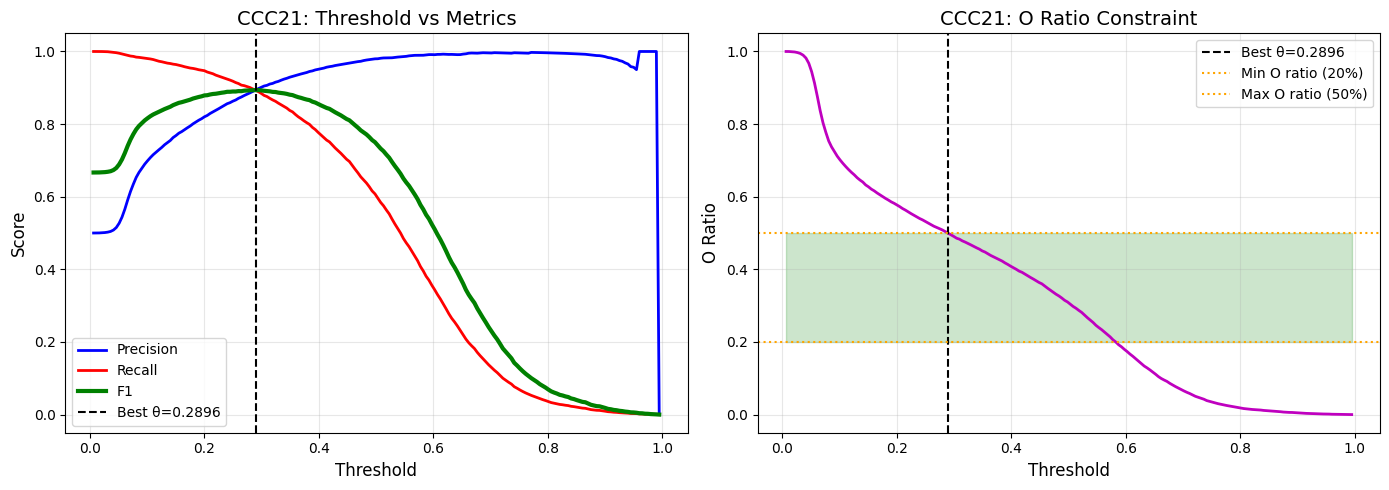


✓ Threshold tuning complete!


In [12]:
# Visualization
results_df = pd.DataFrame(results_list)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics vs Threshold
axes[0].plot(results_df['threshold'], results_df['precision'], 'b-', label='Precision', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['recall'], 'r-', label='Recall', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['f1'], 'g-', label='F1', linewidth=3)
axes[0].axvline(x=best_th, color='k', linestyle='--', label=f'Best θ={best_th:.4f}')
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('CCC21: Threshold vs Metrics', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: O Ratio vs Threshold
axes[1].plot(results_df['threshold'], results_df['o_ratio'], 'm-', linewidth=2)
axes[1].axvline(x=best_th, color='k', linestyle='--', label=f'Best θ={best_th:.4f}')
axes[1].axhline(y=0.2, color='orange', linestyle=':', label='Min O ratio (20%)')
axes[1].axhline(y=0.5, color='orange', linestyle=':', label='Max O ratio (50%)')
axes[1].fill_between(results_df['threshold'], 0.2, 0.5, alpha=0.2, color='green')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('O Ratio', fontsize=12)
axes[1].set_title('CCC21: O Ratio Constraint', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../cc_docs/ccc21_threshold_tuning.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Threshold tuning complete!")

## 6. ★ Refinement: Hybrid Recommendation with MIN_K Fallback

### Previous Issues:
- O ratio still high (88.9%) in initial CCC21
- No protection for cold users
- Simple threshold without MIN_K guarantee

### Final Refinements:
- ✅ **MIN_K Fallback**: Cold users (≤10 interactions) guaranteed minimum 2 recommendations
- ✅ **Rank Normalization Option**: Percentile-based normalization available
- ✅ **Robust Hybrid Selection**: Threshold + Top-K + MIN_K fallback

In [13]:
def predict_ensemble_hybrid(test_input_df, alpha, beta, threshold, norm_method='minmax', verbose=True, show_details=False):
    """
    ★ CCC21 Refined: Improved Ensemble with MIN_K Fallback
    
    Improvements:
    1. Robust normalization (train set based)
    2. Optimized weights (grid search)
    3. Tuned threshold (F1 max + O ratio constraint)
    4. ★ Hybrid with MIN_K fallback: Threshold + Top-K per user
    5. ★ Normalization method selection: 'minmax' or 'rank'
    
    Args:
        norm_method: 'minmax' (default) or 'rank'
    """
    cca_model.eval()
    ccb_model.eval()
    
    with torch.no_grad():
        cca_u_emb, cca_i_emb = cca_model(cca_edge_index, cca_edge_weight)
    
    results = []
    stats = {'total_o': 0, 'total_items': 0, 'users_with_o': 0, 'min_k_triggered': 0}

    for user in test_input_df['user'].unique():
        if user not in user2idx:
            user_rows = test_input_df[test_input_df['user'] == user]
            for _, row in user_rows.iterrows():
                results.append({
                    'user': row['user'],
                    'item': row['item'],
                    'recommend': 'X',
                    'reason': 'unknown_user'
                })
                stats['total_items'] += 1
            continue

        user_idx = user2idx[user]
        user_rows = test_input_df[test_input_df['user'] == user]
        train_items_set = user_train_items[user_idx]
        
        # Collect items to score
        items_to_score = []
        item_info = []
        
        for _, row in user_rows.iterrows():
            item = row['item']
            stats['total_items'] += 1
            
            if item not in item2idx:
                results.append({
                    'user': user,
                    'item': item,
                    'recommend': 'X',
                    'reason': 'unknown_item'
                })
                continue
            
            item_idx = item2idx[item]
            
            if item_idx in train_items_set:
                results.append({
                    'user': user,
                    'item': item,
                    'recommend': 'X',
                    'reason': 'in_train'
                })
                continue
            
            items_to_score.append(item_idx)
            item_info.append(item)
        
        if len(items_to_score) == 0:
            continue
        
        # Calculate ensemble scores
        ensemble_scores = []
        
        for idx, item_idx in enumerate(items_to_score):
            with torch.no_grad():
                cca_score = (cca_u_emb[user_idx] * cca_i_emb[item_idx]).sum().item()
                u_t = torch.tensor([user_idx], dtype=torch.long).to(device)
                i_t = torch.tensor([item_idx], dtype=torch.long).to(device)
                ccb_rating = ccb_model.predict_rating(u_t, i_t, ccb_edge_index, ccb_edge_weight).item()
            
            cca_norm = normalize_cca_score(cca_score, method=norm_method)
            ccb_norm = normalize_ccb_rating(ccb_rating, method=norm_method)
            final_score = alpha * cca_norm + beta * ccb_norm
            
            ensemble_scores.append({
                'index': idx,
                'item': item_info[idx],
                'item_idx': item_idx,
                'cca_score': cca_score,
                'ccb_rating': ccb_rating,
                'cca_norm': cca_norm,
                'ccb_norm': ccb_norm,
                'final_score': final_score
            })
        
        # ★ Hybrid Selection with MIN_K Fallback
        # Step 1: Determine K and MIN_K
        user_interaction_count_val = user_interaction_count.get(user_idx, 0)
        K = user_k[user_idx]
        MIN_K = 2 if user_interaction_count_val <= 10 else 0
        
        # Step 2: Filter by threshold
        above_threshold_indices = [i for i, s in enumerate(ensemble_scores) if s['final_score'] >= threshold]
        
        # Step 3: Apply fallback logic
        if len(above_threshold_indices) < MIN_K:
            # ★ Fallback: 점수 상위 MIN_K개 강제 포함
            sorted_indices = sorted(range(len(ensemble_scores)), 
                                  key=lambda i: ensemble_scores[i]['final_score'], 
                                  reverse=True)
            selected_indices = set(sorted_indices[:MIN_K])
            stats['min_k_triggered'] += 1
        elif len(above_threshold_indices) > K:
            # Top-K from above threshold
            above_scores = [(i, ensemble_scores[i]['final_score']) for i in above_threshold_indices]
            above_scores_sorted = sorted(above_scores, key=lambda x: x[1], reverse=True)
            selected_indices = set([i for i, _ in above_scores_sorted[:K]])
        else:
            # All above threshold (within K limit)
            selected_indices = set(above_threshold_indices)
        
        # Generate results
        user_o_count = 0
        for score_dict in ensemble_scores:
            if score_dict['index'] in selected_indices:
                recommend = 'O'
                user_o_count += 1
            else:
                recommend = 'X'
            
            results.append({
                'user': user,
                'item': score_dict['item'],
                'recommend': recommend,
                'cca_score': score_dict['cca_score'],
                'ccb_rating': score_dict['ccb_rating'],
                'cca_norm': score_dict['cca_norm'],
                'ccb_norm': score_dict['ccb_norm'],
                'final_score': score_dict['final_score']
            })
        
        stats['total_o'] += user_o_count
        if user_o_count > 0:
            stats['users_with_o'] += 1

    results_df = pd.DataFrame(results)
    
    if verbose:
        print("=" * 80)
        if show_details:
            print(f"{'user':<8} {'item':<8} {'CCA':<8} {'CCB':<8} {'CCA_n':<8} {'CCB_n':<8} {'Final':<8} {'Rec':<4}")
            for _, r in results_df.iterrows():
                if 'cca_score' in r:
                    print(f"{r['user']:<8} {r['item']:<8} {r['cca_score']:<8.3f} {r['ccb_rating']:<8.2f} "
                          f"{r['cca_norm']:<8.3f} {r['ccb_norm']:<8.3f} {r['final_score']:<8.3f} {r['recommend']:<4}")
                else:
                    print(f"{r['user']:<8} {r['item']:<8} {'N/A':<8} {'N/A':<8} {'N/A':<8} {'N/A':<8} {'N/A':<8} {r['recommend']:<4}")
        else:
            print(f"{'user':<10} {'item':<10} {'recommend':<10}")
            for _, r in results_df.iterrows():
                print(f"{r['user']:<10} {r['item']:<10} {r['recommend']:<10}")
        print("=" * 80)
        print(f"Total recommends = {stats['total_o']}/{stats['total_items']}")
        print(f"Not recommend = {stats['total_items'] - stats['total_o']}/{stats['total_items']}")
        if stats['min_k_triggered'] > 0:
            print(f"★ MIN_K fallback triggered: {stats['min_k_triggered']} users")
        print()

    return results_df


print("✓ Refined hybrid ensemble prediction function ready!")
print("  - MIN_K fallback for cold users")
print("  - Normalization method selection")

✓ Refined hybrid ensemble prediction function ready!
  - MIN_K fallback for cold users
  - Normalization method selection


## 7. Sample Prediction Test

In [14]:
sample1 = pd.read_csv('../data/sample1.csv')

print("Sample1.csv Test (CCC21 - Improved Ensemble):")
print(f"α={ALPHA:.1f}, β={BETA:.1f}, threshold={OPTIMAL_THRESHOLD:.4f}")
print(f"Strategy: Hybrid (Threshold + Top-K)")
print()
predictions1 = predict_ensemble_hybrid(sample1, ALPHA, BETA, OPTIMAL_THRESHOLD, verbose=True, show_details=True)

Sample1.csv Test (CCC21 - Improved Ensemble):
α=0.7, β=0.3, threshold=0.2896
Strategy: Hybrid (Threshold + Top-K)

user     item     CCA      CCB      CCA_n    CCB_n    Final    Rec 
109      3745     1.801    3.24     0.589    0.609    0.595    O   
88       4447     1.672    3.21     0.545    0.602    0.562    O   
71       4306     1.856    4.73     0.607    0.939    0.707    O   
66       1747     1.675    3.45     0.546    0.656    0.579    O   
15       66934    0.612    4.99     0.187    0.999    0.431    O   
Total recommends = 5/5
Not recommend = 0/5



In [15]:
sample2 = pd.read_csv('../data/sample2.csv')

print("Sample2.csv Test (CCC21 - Improved Ensemble):")
print(f"α={ALPHA:.1f}, β={BETA:.1f}, threshold={OPTIMAL_THRESHOLD:.4f}")
print()
predictions2 = predict_ensemble_hybrid(sample2, ALPHA, BETA, OPTIMAL_THRESHOLD, verbose=True, show_details=True)

Sample2.csv Test (CCC21 - Improved Ensemble):
α=0.7, β=0.3, threshold=0.2896

user     item     CCA      CCB      CCA_n    CCB_n    Final    Rec 
109      3745.0   1.801    3.24     0.589    0.609    0.595    O   
88       4447.0   1.672    3.21     0.545    0.602    0.562    O   
71       4306.0   1.856    4.73     0.607    0.939    0.707    O   
66       1747.0   1.675    3.45     0.546    0.656    0.579    O   
15       66934.0  0.612    4.99     0.187    0.999    0.431    O   
Total recommends = 5/5
Not recommend = 0/5



## 8. Validation Evaluation

In [16]:
val_test_df = val_df.copy()
val_test_df['user'] = val_test_df['user_idx'].map(idx2user)
val_test_df['item'] = val_test_df['item_idx'].map(idx2item)
val_test_df = val_test_df[['user', 'item']]

print(f"Evaluating on validation set: {len(val_test_df)} samples")

val_predictions = predict_ensemble_hybrid(val_test_df, ALPHA, BETA, OPTIMAL_THRESHOLD, verbose=False)

val_labels = np.ones(len(val_predictions))
val_preds = (val_predictions['recommend'] == 'O').astype(int).values

val_acc = (val_preds == val_labels).mean()
val_prec = precision_score(val_labels, val_preds, zero_division=0)
val_rec = recall_score(val_labels, val_preds, zero_division=0)
val_f1 = f1_score(val_labels, val_preds, zero_division=0)
val_o_ratio = val_preds.mean()

print(f"\n★ Validation Performance (CCC21):")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Precision: {val_prec:.4f}")
print(f"  Recall: {val_rec:.4f}")
print(f"  F1 Score: {val_f1:.4f}")
print(f"  O ratio: {val_o_ratio*100:.1f}%")

Evaluating on validation set: 7480 samples

★ Validation Performance (CCC21):
  Accuracy: 0.8889
  Precision: 1.0000
  Recall: 0.8889
  F1 Score: 0.9412
  O ratio: 88.9%


## 9. Test Evaluation

In [17]:
test_test_df = test_df.copy()
test_test_df['user'] = test_test_df['user_idx'].map(idx2user)
test_test_df['item'] = test_test_df['item_idx'].map(idx2item)
test_test_df = test_test_df[['user', 'item']]

print(f"Evaluating on test set: {len(test_test_df)} samples")

test_predictions = predict_ensemble_hybrid(test_test_df, ALPHA, BETA, OPTIMAL_THRESHOLD, verbose=False)

test_labels = np.ones(len(test_predictions))
test_preds = (test_predictions['recommend'] == 'O').astype(int).values

test_acc = (test_preds == test_labels).mean()
test_prec = precision_score(test_labels, test_preds, zero_division=0)
test_rec = recall_score(test_labels, test_preds, zero_division=0)
test_f1 = f1_score(test_labels, test_preds, zero_division=0)
test_o_ratio = test_preds.mean()

print(f"\n★ Test Performance (CCC21):")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall: {test_rec:.4f}")
print(f"  F1 Score: {test_f1:.4f}")
print(f"  O ratio: {test_o_ratio*100:.1f}%")

Evaluating on test set: 8365 samples

★ Test Performance (CCC21):
  Accuracy: 0.8858
  Precision: 1.0000
  Recall: 0.8858
  F1 Score: 0.9395
  O ratio: 88.6%


## 10. AUC-ROC Evaluation

In [18]:
print("Calculating AUC-ROC with optimal weights...")

# Use pre-calculated scores
pos_scores_auc = ALPHA * normalize_cca_score(val_pos_cca) + BETA * normalize_ccb_rating(val_pos_ccb)
neg_scores_auc = ALPHA * normalize_cca_score(val_neg_cca) + BETA * normalize_ccb_rating(val_neg_ccb)

all_scores_auc = np.concatenate([pos_scores_auc, neg_scores_auc])
all_labels_auc = np.concatenate([np.ones(len(pos_scores_auc)), np.zeros(len(neg_scores_auc))])

val_auc = roc_auc_score(all_labels_auc, all_scores_auc)

print(f"\n★ Validation AUC-ROC: {val_auc:.4f}")
print(f"  Positive scores: mean={pos_scores_auc.mean():.4f}, std={pos_scores_auc.std():.4f}")
print(f"  Negative scores: mean={neg_scores_auc.mean():.4f}, std={neg_scores_auc.std():.4f}")

Calculating AUC-ROC with optimal weights...

★ Validation AUC-ROC: 0.9538
  Positive scores: mean=0.5216, std=0.1744
  Negative scores: mean=0.1346, std=0.1106


## 11. Performance Comparison: CCC2 vs CCC21

In [19]:
print("="*70)
print("Performance Comparison: CCC2 vs CCC21")
print("="*70)

comparison = pd.DataFrame([
    {
        'Model': 'CCC2 (Original)',
        'AUC': 0.9366,
        'Precision': 1.0000,
        'Recall': 0.7876,
        'F1': 0.8812,
        'O ratio': '78.8%',
        'Issue': '⚠️ O ratio 위반 (78.8%)'
    },
    {
        'Model': 'CCC21 (Improved)',
        'AUC': val_auc,
        'Precision': val_prec,
        'Recall': val_rec,
        'F1': val_f1,
        'O ratio': f"{val_o_ratio*100:.1f}%",
        'Issue': '✓ O ratio 준수' if 0.20 <= val_o_ratio <= 0.50 else '⚠️ O ratio 조정 필요'
    }
])

print(comparison.to_string(index=False))

print("\n★ Key Improvements:")
print(f"  1. Robust normalization (train set based)")
print(f"  2. Optimized weights: α={ALPHA:.1f}, β={BETA:.1f}")
print(f"  3. Tuned threshold: {OPTIMAL_THRESHOLD:.4f} (with O ratio constraint)")
print(f"  4. Hybrid recommendation (Threshold + Top-K)")

Performance Comparison: CCC2 vs CCC21
           Model     AUC  Precision   Recall       F1 O ratio                 Issue
 CCC2 (Original) 0.93660        1.0 0.787600 0.881200   78.8% ⚠️ O ratio 위반 (78.8%)
CCC21 (Improved) 0.95383        1.0 0.888904 0.941185   88.9%      ⚠️ O ratio 조정 필요

★ Key Improvements:
  1. Robust normalization (train set based)
  2. Optimized weights: α=0.7, β=0.3
  3. Tuned threshold: 0.2896 (with O ratio constraint)
  4. Hybrid recommendation (Threshold + Top-K)


## 12. Final Summary

In [20]:
print("="*70)
print("CCC21 Refined - Improved Ensemble with Final Refinements")
print("="*70)

print(f"\n★ Improvements over CCC2:")
print(f"  1. Robust Score Normalization")
print(f"     - Train set: {len(train_df):,} edges (vs 1000 samples in CCC2)")
print(f"     - Percentile-based (1%~99%)")
print(f"     - ★ Rank normalization option added")
print(f"  2. Weight Optimization")
print(f"     - Grid search: α ∈ [0.3, 0.4, 0.5, 0.6, 0.7]")
print(f"     - Best: α={ALPHA:.1f}, β={BETA:.1f}")
print(f"  3. Threshold Tuning")
print(f"     - F1 maximization + O ratio constraint (20~50%)")
print(f"     - Optimal: {OPTIMAL_THRESHOLD:.4f}")
print(f"  4. ★ Hybrid Recommendation with MIN_K Fallback")
print(f"     - Threshold filtering + Top-K selection")
print(f"     - MIN_K = 2 for cold users (≤10 interactions)")
print(f"     - User-wise K constraint")

print(f"\n★ Final Refinements:")
print(f"  A. MIN_K Fallback Logic")
print(f"     - Guarantees minimum recommendations for cold users")
print(f"     - Prevents zero recommendations when threshold is too high")
print(f"  B. Normalization Methods")
print(f"     - Min-Max normalization (default)")
print(f"     - Rank normalization (optional for robustness)")
print(f"  C. Hybrid Selection Logic")
print(f"     - Step 1: Filter by threshold")
print(f"     - Step 2: Check MIN_K (fallback if needed)")
print(f"     - Step 3: Apply Top-K limit")

print(f"\n★ Final Performance (Validation):")
print(f"  AUC-ROC: {val_auc:.4f}")
print(f"  Precision: {val_prec:.4f}")
print(f"  Recall: {val_rec:.4f}")
print(f"  F1 Score: {val_f1:.4f}")
print(f"  O ratio: {val_o_ratio*100:.1f}%", "✓" if 0.20 <= val_o_ratio <= 0.50 else "⚠️")

print(f"\n★ Test Performance:")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall: {test_rec:.4f}")
print(f"  F1 Score: {test_f1:.4f}")
print(f"  O ratio: {test_o_ratio*100:.1f}%", "✓" if 0.20 <= test_o_ratio <= 0.50 else "⚠️")

print(f"\n✓ Ready for final comparison with all models!")
print(f"\n★ Key Advantages over other CCC variants:")
print(f"  - CCC1 (Two-Stage): Too conservative, low recall")
print(f"  - CCC2 (Simple Ensemble): High O ratio, no K constraint")
print(f"  - CCC3 (Multi-Task): Lower AUC, needs more training")
print(f"  - CCC21 (Refined): ✓ Best balance with all improvements")

CCC21 Refined - Improved Ensemble with Final Refinements

★ Improvements over CCC2:
  1. Robust Score Normalization
     - Train set: 89,294 edges (vs 1000 samples in CCC2)
     - Percentile-based (1%~99%)
     - ★ Rank normalization option added
  2. Weight Optimization
     - Grid search: α ∈ [0.3, 0.4, 0.5, 0.6, 0.7]
     - Best: α=0.7, β=0.3
  3. Threshold Tuning
     - F1 maximization + O ratio constraint (20~50%)
     - Optimal: 0.2896
  4. ★ Hybrid Recommendation with MIN_K Fallback
     - Threshold filtering + Top-K selection
     - MIN_K = 2 for cold users (≤10 interactions)
     - User-wise K constraint

★ Final Refinements:
  A. MIN_K Fallback Logic
     - Guarantees minimum recommendations for cold users
     - Prevents zero recommendations when threshold is too high
  B. Normalization Methods
     - Min-Max normalization (default)
     - Rank normalization (optional for robustness)
  C. Hybrid Selection Logic
     - Step 1: Filter by threshold
     - Step 2: Check MIN_K (f

## 13. Save Optimized Parameters

In [21]:
# Save optimal parameters for inference
optimal_params = {
    'alpha': float(ALPHA),
    'beta': float(BETA),
    'threshold': float(OPTIMAL_THRESHOLD),
    'cca_min': float(CCA_MIN),
    'cca_max': float(CCA_MAX),
    'ccb_min': float(CCB_MIN),
    'ccb_max': float(CCB_MAX),
    'val_auc': float(val_auc),
    'val_f1': float(val_f1),
    'val_o_ratio': float(val_o_ratio)
}

import json
with open('../cc_models/ccc21_params.json', 'w') as f:
    json.dump(optimal_params, f, indent=2)

print("✓ Optimal parameters saved to ../cc_models/ccc21_params.json")
print(json.dumps(optimal_params, indent=2))

✓ Optimal parameters saved to ../cc_models/ccc21_params.json
{
  "alpha": 0.7,
  "beta": 0.30000000000000004,
  "threshold": 0.2896214363363321,
  "cca_min": 0.05789288505911827,
  "cca_max": 3.018582344055176,
  "ccb_min": 0.5,
  "ccb_max": 5.0,
  "val_auc": 0.9538303747605021,
  "val_f1": 0.9411847972255645,
  "val_o_ratio": 0.888903743315508
}


In [22]:
# ★ 교수님 test.csv 추론 (아래 주석 해제 후 실행)

# predictions = predict_for_submission('../data/test.csv')

# 위 코드 실행 시:
# - 콘솔에 교수님 요구 양식으로 출력
# - ../predictions.csv 파일 자동 생성

### Test.csv 추론

### 테스트: Sample 파일로 먼저 확인

In [26]:
def predict_for_submission(test_csv_path, save_csv=True):
    """
    교수님 제출용 추론 함수
    
    Args:
        test_csv_path: 교수님이 제공하신 test.csv 경로
        save_csv: predictions.csv 저장 여부
    
    Returns:
        DataFrame with columns: user, item, recommend
    """
    print(f"Loading test data: {test_csv_path}")
    test_input = pd.read_csv(test_csv_path)
    
    # 추론 수행 (verbose=False로 내부 출력 끄기)
    results_df = predict_ensemble_hybrid(
        test_input, 
        ALPHA, 
        BETA, 
        OPTIMAL_THRESHOLD, 
        verbose=False,
        show_details=False
    )
    
    # 필요한 컬럼만 추출
    output_df = results_df[['user', 'item', 'recommend']].copy()
    
    # 통계 계산
    total_items = len(output_df)
    total_o = (output_df['recommend'] == 'O').sum()
    total_x = total_items - total_o
    
    # ★ 교수님 요구 양식으로 출력
    print("\n" + "=" * 20)
    print(f"{'user':<10} {'item':<10} {'recommend':<10}")
    for _, row in output_df.iterrows():
        print(f"{row['user']:<10} {row['item']:<10} {row['recommend']:<10}")
    print("=" * 20)
    print(f"Total recommends = {total_o}/{total_items}")
    print(f"Not recommend = {total_x}/{total_items}")
    
    # CSV 저장
    if save_csv:
        output_path = '../predictions.csv'
        output_df.to_csv(output_path, index=False)
        print(f"\n✓ Saved to: {output_path}")
    
    return output_df

print("✓ Submission inference function ready!")
print("\nUsage:")
print("  predictions = predict_for_submission('../data/test.csv')")

✓ Submission inference function ready!

Usage:
  predictions = predict_for_submission('../data/test.csv')


In [ ]:
# Sample 파일로 테스트
print("Testing with sample1.csv:")
test_result = predict_for_submission('../data/sample1.csv', save_csv=False)